In [29]:
# Imports
from pathlib import Path
from sqlutils import sqlutils
import pandas as pd
import string
from multiprocessing import cpu_count
from concurrent.futures import ThreadPoolExecutor
import unidecode
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [30]:
# Déterminer le chemin du script
script_path = Path().resolve()

# # Select des avis depuis la base de données et depuis le chemin du script
bdd = sqlutils(script_path / "../../data/friands.db")
query = f"SELECT avis.id_restaurant, avis.contenu_avis, restaurants.nom FROM avis JOIN restaurants ON avis.id_restaurant = restaurants.id_restaurant"
success, t_avis = bdd.select(query)

if not success:
    print("Erreur lors de l'extraction des avis depuis la base de données")
    print(t_avis)
else:
    print(
        f"Extraction de {len(t_avis)} enregistrements depuis la base de données réussie"
    )

# # Insérer les champs extraits de la base de données dans un dataframe
df = pd.DataFrame(
    t_avis,
    columns=[
        "id_restaurant",
        "contenu_avis",
        "nom",
    ],
)

Extraction de 4573 enregistrements depuis la base de données réussie


In [31]:
# Mots vides
# Chargement du fichier stopwords-fr.txt, qui contient un mot vide par ligne
with open(script_path / "stopwords-fr.txt", "r") as f:
    mots_vides = f.read().splitlines()

# Ce fichier stopwords-fr.txt a été créer à partir de la liste de mots vides de nltk
# puis en ajoutant des mots vides provenant de https://github.com/stopwords-iso/stopwords-fr/blob/master/stopwords-fr.txt
# Des mots propres à l'univers de la restauration, mais trop génériques, ont aussi été enlevés (ex: restaurant, cuisine, etc.)
# Enfin, les mots ont été nettoyés pour enlever les caractères diacritiques.
# le fichier fourni ici est déjà propre et ne nécessite plus de traitement.

# On ajoute aux mots vides les noms des restaurants
translation_table = str.maketrans(
    {char: " " for char in string.punctuation + string.digits}
)

noms = df["nom"].str.lower().unique()
noms = [l for n in noms for l in n.split()]
noms = [unidecode.unidecode(n).lower().translate(translation_table) for n in noms]
mots_vides.extend(noms)

In [32]:
def clean_avis(avis):
    avis = unidecode.unidecode(avis).lower().translate(translation_table)
    return " ".join(mot for mot in avis.split() if mot not in mots_vides)

In [33]:
# Moulinette pour nettoyer les avis en multi-threading
n_jobs = cpu_count()
with ThreadPoolExecutor(max_workers=n_jobs) as executor:
    results = executor.map(clean_avis, df["contenu_avis"])
df["avis_clean"] = pd.DataFrame(results)

In [34]:
# import spacy

# nlp = spacy.load("fr_core_news_sm")


# def lemmatize_text(text):
#     doc = nlp(text)
#     return " ".join(token.lemma_ for token in doc)


# df["avis_clean"] = df["avis_clean"].apply(lemmatize_text)

In [35]:
# import nltk

# nltk.download("punkt")
# from nltk.stem.snowball import FrenchStemmer

# stemmer = FrenchStemmer()


# def lemmatize_text(text):
#     tokens = nltk.word_tokenize(text, language="french")
#     return " ".join(stemmer.stem(token) for token in tokens)


# df["avis_clean"] = df["avis_clean"].apply(lemmatize_text)

In [36]:
# import stanza

# stanza.download("fr")
# nlp = stanza.Pipeline("fr")


# def lemmatize_text(text):
#     doc = nlp(text)
#     return " ".join(word.lemma for sentence in doc.sentences for word in sentence.words)


# df["avis_clean"] = df["avis_clean"].apply(lemmatize_text)

In [37]:
# Compiler tous les avis par restaurant sous forme d'une liste de mots
df_grouped = df.groupby("id_restaurant")["avis_clean"].apply(" ".join).reset_index()

In [38]:
# Extraire sous forme d'un pandas.Series l'avis_clean pour le restaurant d'id 1
# liste_avis_restaurant_1 = df_grouped.loc[
#     df_grouped["id_restaurant"] == 1, "avis_clean"
# ].squeeze()

# # Transformer en liste de mots en splittant sur espace
# liste_mots_restaurant_1 = liste_avis_restaurant_1.split()

# # Transformer en pandas series et appliquer values_count
# serie_mots_restaurant_1 = pd.Series(liste_mots_restaurant_1).value_counts()

# # transformer en dico
# dico_mots = serie_mots_restaurant_1.to_dict()
# Transformer en dico pour tous les restaurants
dico_mots = {}
for id_restaurant, avis in df_grouped.itertuples(index=False):
    mots = avis.split()
    serie_mots = pd.Series(mots).value_counts()
    dico_mots[id_restaurant] = serie_mots.to_dict()

Wordcloud pour le restaurant KUMA cantine


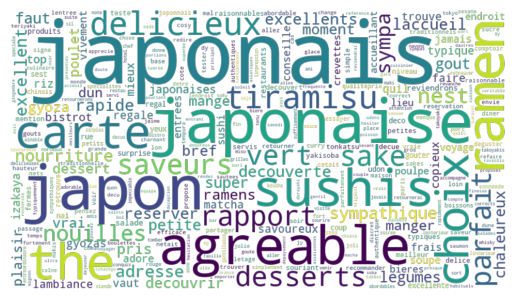

Wordcloud pour le restaurant Mattsam Restaurant Messob


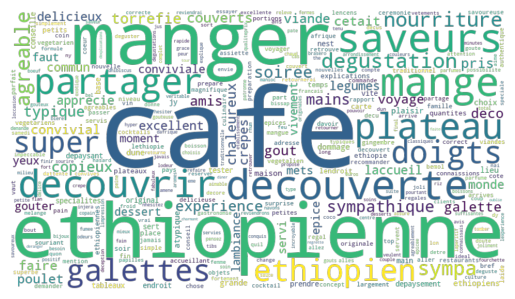

Wordcloud pour le restaurant Brasserie des Confluences


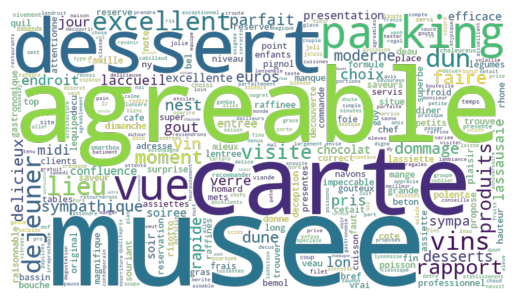

Wordcloud pour le restaurant Christian Tetedoie


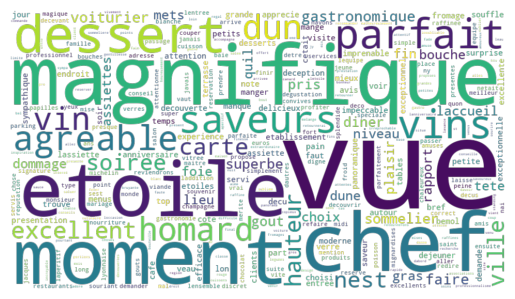

Wordcloud pour le restaurant Gang Nam


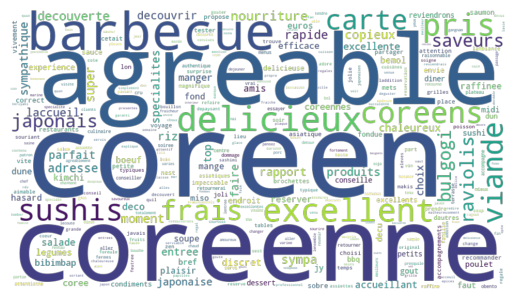

Wordcloud pour le restaurant Crêperie La Marie Morgane


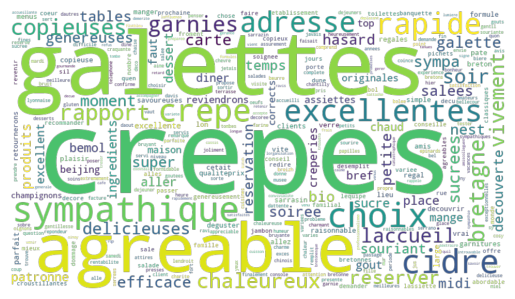

Wordcloud pour le restaurant Fiston - Bouchon Lyonnais


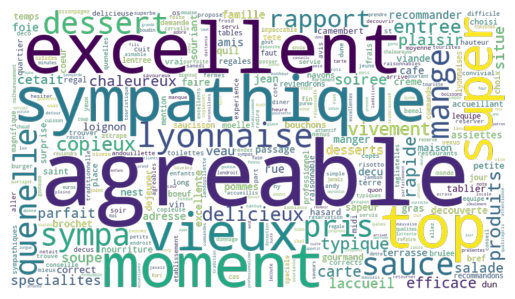

Wordcloud pour le restaurant Les Terrasses de Lyon


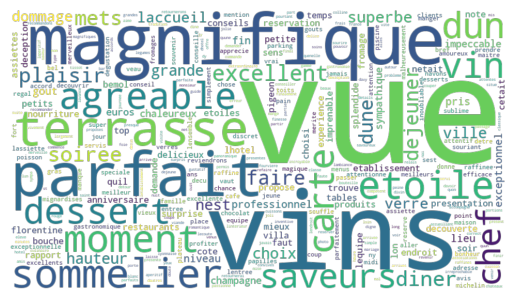

Wordcloud pour le restaurant Empanadas Club


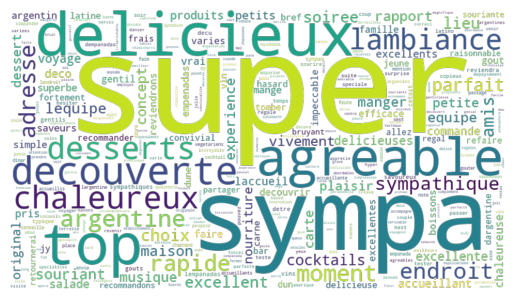

Wordcloud pour le restaurant Kenbo


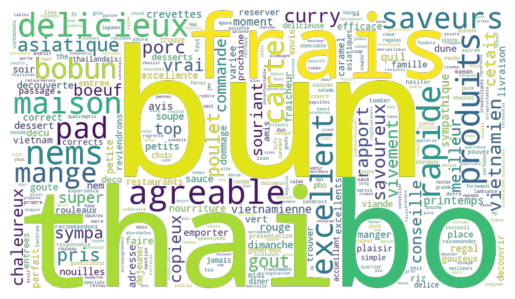

In [39]:
# Générer un wordcloud
def makeImage(text):
    nuage = WordCloud(
        background_color=None,
        mode="RGBA",
        max_words=350,
        width=960,  # Augmente la largeur
        height=540,  # Augmente la hauteur
    )
    # generate word cloud
    nuage.generate_from_frequencies(text)

    # show
    plt.imshow(nuage, interpolation="bilinear")
    plt.axis("off")
    plt.show()

    # Enregistrer l'image dans le dossier images
    nom_image = f"wordcloud_{id_restaurant}.png"
    nuage.to_file(script_path / "../../app/assets" / nom_image)


# Faire une boucle sur dico_mots pour afficher toutes les images
for id_restaurant, mots in dico_mots.items():
    nom_restaurant = df.loc[df["id_restaurant"] == id_restaurant, "nom"].iloc[0]
    print(f"Wordcloud pour le restaurant {nom_restaurant}")
    makeImage(mots)